In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
import time

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folders = os.listdir(data_dir)
    for folder in folders:
        folder_path = os.path.join(data_dir, folder)
        files = os.listdir(folder_path)
        for file in files:
            fpath = os.path.join(folder_path, file)
            filepaths.append(fpath)
            labels.append(folder)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [3]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    tr_gen = ImageDataGenerator(preprocessing_function= None)
    ts_gen = ImageDataGenerator(preprocessing_function= None)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= batch_size)

    return train_gen, valid_gen, test_gen

In [5]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [7]:
data_dir = './Pill Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 16000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


In [12]:
class_count = len(list(train_gen.class_indices.keys())) # to define the number of classes in the dense layer

# Define the base model (InceptionV3)
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, weights=None, input_shape=(224, 224, 3), pooling='max')

# Create your complete model by adding custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(class_count, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

batch_size = 32  # set batch size for training
epochs = 10  # number of all epochs in training

# Define ReduceLROnPlateau callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Record start time
start_time = time.time()

history = model.fit(x=train_gen, epochs=epochs, batch_size=batch_size,
                    validation_data=valid_gen, shuffle=True,
                    callbacks=[lr_callback])

# Record end time
end_time = time.time()

# Calculate training duration
training_duration = end_time - start_time
print(f"Training duration: {training_duration} seconds")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21,823,274
Trainable params: 21,788,842
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/10
400/400 [==============================] - 2929s 7s/step - loss: 2.2564 - accuracy: 0.1896 - val_loss: 2.0638 - val_accuracy: 0.2595 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - 2874s 7s/step - loss: 1.4548 - accuracy: 0.4631 - val_loss: 1.0927 - val_accuracy: 0.6505 - 

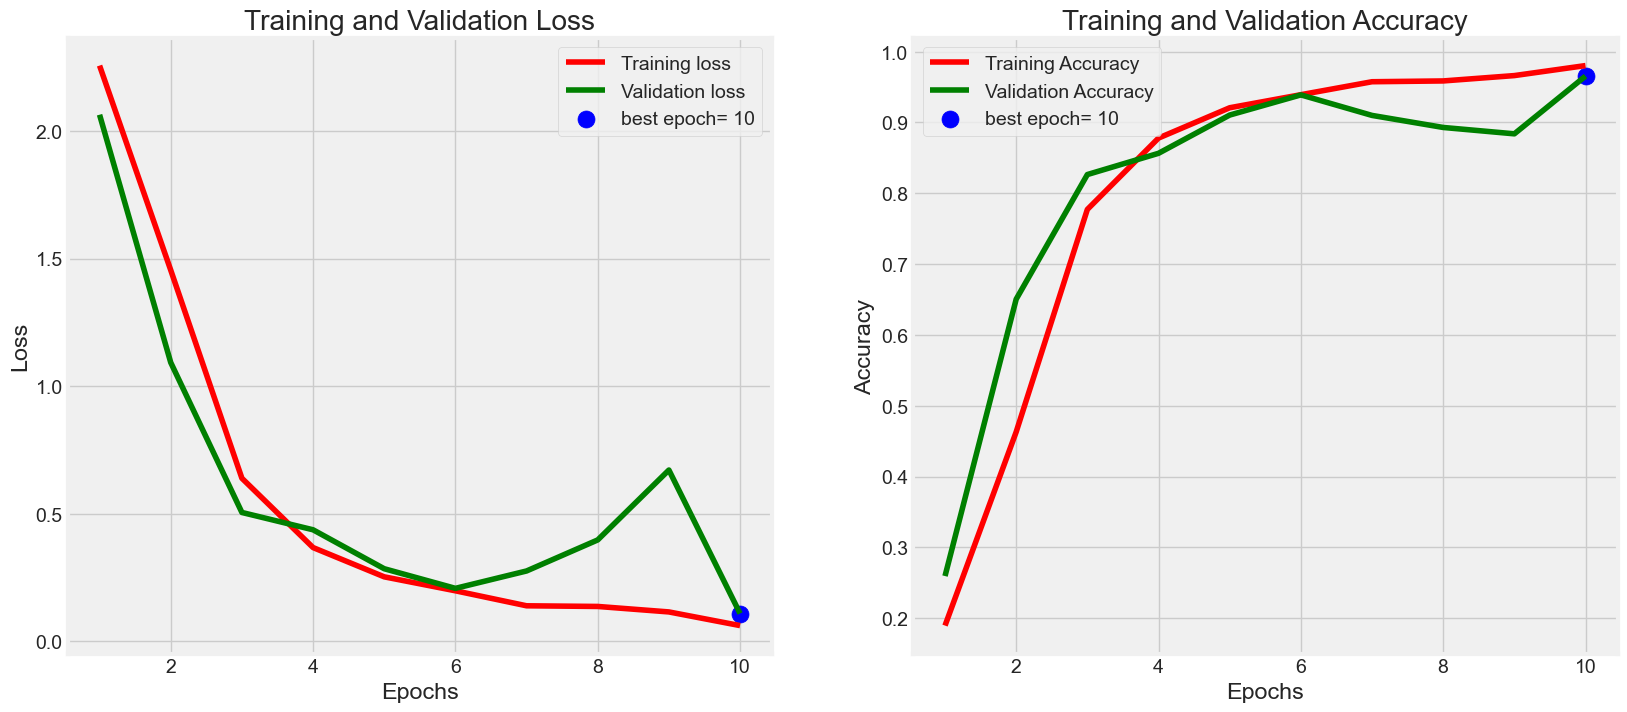

In [13]:
plot_training(history)

In [14]:
ts_length = len(test_df)
test_batch_size = 32
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

25/25 [==============================] - 74s 3s/step - loss: 0.1073 - accuracy: 0.9615
Train Loss:  0.06875677406787872
Train Accuracy:  0.9760000109672546
--------------------
Validation Loss:  0.11122466623783112
Validation Accuracy:  0.9679999947547913
--------------------
Test Loss:  0.10730095952749252
Test Accuracy:  0.9614999890327454


In [15]:
preds = model.predict_generator(test_gen)
y_pred_class = np.argmax(preds, axis=1)
print(y_pred_class)

[1 6 8 ... 4 4 2]


Confusion Matrix, Without Normalization
[[190   3   0   0   0   1   5   0   0   1]
 [  2 197   0   0   0   1   0   0   0   0]
 [  0   0 196   1   2   0   0   0   0   1]
 [  1  11   0 181   5   1   0   0   0   1]
 [  0   1   0   0 198   0   0   0   0   1]
 [  0   2   1   1   0 193   1   0   0   2]
 [  0   1   1   0   0   0 197   0   1   0]
 [  0   0   0  18   0   0   0 180   0   2]
 [  0   0   0   1   1   0   0   0 198   0]
 [  0   1   2   1   2   0   1   0   0 193]]
              precision    recall  f1-score   support

      Alaxan       0.98      0.95      0.97       200
    Bactidol       0.91      0.98      0.95       200
      Bioflu       0.98      0.98      0.98       200
    Biogesic       0.89      0.91      0.90       200
     DayZinc       0.95      0.99      0.97       200
    Decolgen       0.98      0.96      0.97       200
    Fish Oil       0.97      0.98      0.98       200
    Kremil S       1.00      0.90      0.95       200
     Medicol       0.99      0.99      0.9

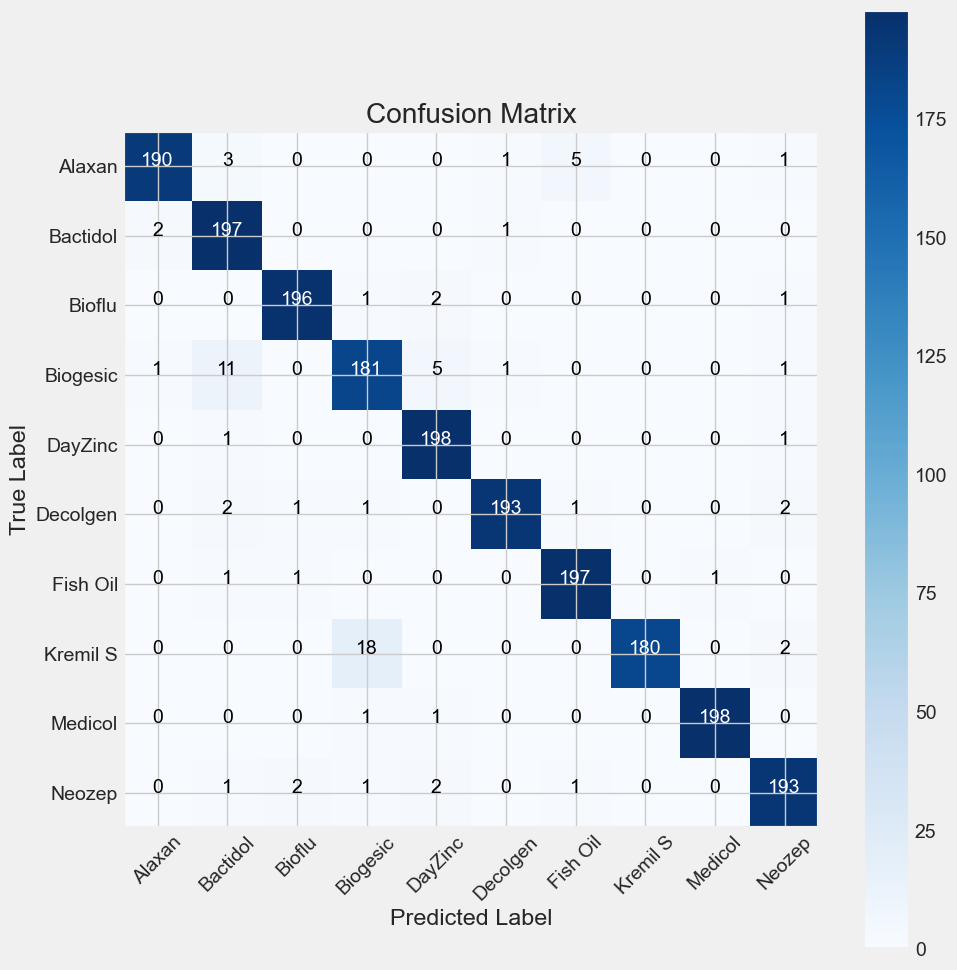

In [16]:
class_dict = test_gen.class_indices
classes = list(class_dict.keys())

# Confusion matrix
conf_matrix = confusion_matrix(test_gen.classes, y_pred_class)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.tight_layout()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Data')
plt.show()

# Classification report
print(classification_report(test_gen.classes, y_pred_class, target_names= classes))

In [17]:
model.save("InceptionV3.h5")